# KoBERT 모델을 활용한 영화 리뷰 감성분석

## kobert를 사용하기 위한 kobert_transformers 패키지 다운로드

https://github.com/monologg/KoBERT-Transformers.git


In [ ]:
!wget https://raw.githubusercontent.com/monologg/KoBERT-Transformers/master/kobert_transformers/tokenization_kobert.py -O ./tokenization_kobert.py

In [ ]:
!pip3 install kobert-transformers

## 패키지 임포트

- kobert_transformers를 활용해 kobert 모델을 불러옵니다.
- tokenization_kobert는 kobert github에서 tokenizer를 가져오기위해 사용한 모듈입니다.

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from kobert_transformers import get_kobert_model, get_distilkobert_model
from tokenization_kobert import KoBertTokenizer

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

import numpy as np

## 데이터 준비

- 네이버 영화 리뷰 데이터
- 학습 데이터 15만개, 테스트 데이터 5만개로 이루어져 있습니다.

https://github.com/e9t/nsmc.git

In [ ]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt -O ./nsmc_train.tsv
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt -O ./nsmc_test.tsv

In [6]:
train_reviews = [l.rstrip().split('\t') for l in open('./nsmc_train.tsv').readlines()[1:]]
test_reviews = [l.rstrip().split('\t') for l in open('./nsmc_test.tsv').readlines()[1:]]

In [8]:
# id, review, label
test_reviews[0], len(test_reviews)

(['6270596', '굳 ㅋ', '1'], 50000)

In [14]:
sents, labels = tuple(zip(*[(sentence, int(label)) for _, sentence, label in train_reviews[:100]]))

In [ ]:
list(zip(sents, labels))

In [78]:
train_sentences, train_labels = list(zip(*[(sentence, int(label)) for _, sentence, label in train_reviews[:50000]]))
test_sentences, test_labels = list(zip(*[(sentence, int(label)) for _, sentence, label in test_reviews]))

### EDA

In [ ]:
# 문장 단위로 이루어져 있는지
# 뉴스기사 수집했다면?
# 하나의 본문 -> 여러개의 문장
# seq_len 대략적으로 살펴보기
# 문장으로 분리해야하는지 체크
train_sentences[:20]

In [80]:
sent_len = [len(s) for s in train_sentences]
max(sent_len), min(sent_len), sum(sent_len)/len(sent_len)

(158, 0, 35.48084)

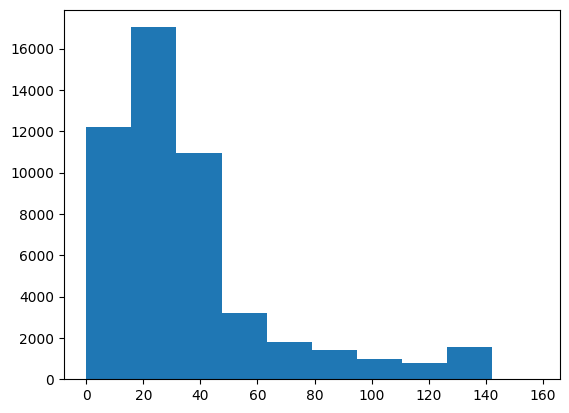

In [81]:
import matplotlib.pyplot as plt

plt.hist(sent_len)
plt.show()

## Configs 설정

In [52]:
max_len = 128 # 문장 최대길이, EDA 필요
batch_size = 64

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [54]:
device

device(type='cuda')

## Input Transformer

- 입력 문장을 bert 입력에 필요한 값들로 바꿔줍니다.
- token_ids : 입력 문장을 토큰화한 값
    - 입력 문장을 토큰화합니다.
    - [CLS], [SEP]토큰을 추가합니다.
    - 토큰들을 id (숫자값)으로 치환합니다.
    - 문장이 길 경우 max_len까지만 사용합니다.
- valid_lengths : 유효 토큰 길이 값
- segment_ids : NSP task에서 문장 구분을 위해 사용합니다.
앞 문장 0, 뒷 문장 1. 여기서는 모두 0입니다.


In [82]:
class InputTransformer:

    def __init__(self, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pad_token = tokenizer.convert_tokens_to_ids(['[PAD]'])[0]

    def transform(self, sentences):
        # 성능개선필요 https://github.com/monologg/KoBERT-nsmc/blob/master/data_loader.py
        tokenized = [self.tokenizer.tokenize(sentence) for sentence in sentences]
        input_ids = [self.tokenizer.convert_tokens_to_ids(['[CLS]'] + tokens + ['[SEP]'])[:self.max_len]
                     for tokens in tokenized]
        valid_lengths = [input_id.index(3) if len(input_id) < self.max_len else self.max_len for input_id in input_ids]
        token_ids = [np.array(input_id + [self.pad_token]*(self.max_len-valid_lengths[i]-1)) for i, input_id in enumerate(input_ids)]
        segment_ids = [np.zeros(self.max_len) for i in range(len(sentences))]

        return list(zip(token_ids, valid_lengths, segment_ids))

# class InputTransformer:

#     def __init__(self, tokenizer, max_len=128):
#         self.tokenizer = tokenizer
#         self.max_len = max_len
#         self.pad_token = tokenizer.convert_tokens_to_ids(['[PAD]'])[0]

#     def transform(self, sentences):
#         inputs = [self.tokenizer(sentence,
#                                  padding='max_length',
#                                  max_length=self.max_len,
#                                  truncation=True)
#                                  for sentence in sentences] #{input_ids, token_type_ids, attention_mask}

#         return inputs

## BERT Dataset

- 문장들을 Input Transformer 처리하고 label을 텐서 자료형으로 변환합니다.

In [83]:
class BERTDataset(Dataset):

    def __init__(self, transformer, sentences, labels=()):
        self.sentences = transformer.transform(sentences)
        self.is_test = False if labels else True
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, i):
        return self.sentences[i], self.labels[i] if not self.is_test else _

    def __len__(self):
        return len(self.sentences)


In [84]:
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')
input_transformer = InputTransformer(tokenizer, max_len)

# train & test 데이터로 나누기
from sklearn.model_selection import train_test_split

trn_sents, valid_sents, trn_labels, valid_labels = train_test_split(train_sentences, train_labels, test_size=0.25, random_state=0, stratify=train_labels, shuffle=True)

train_dataset = BERTDataset(input_transformer, trn_sents, trn_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0)

valid_dataset = BERTDataset(input_transformer, valid_sents, valid_labels)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=0)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


In [85]:
length_list = [l for _, l, _ in train_dataset.sentences]

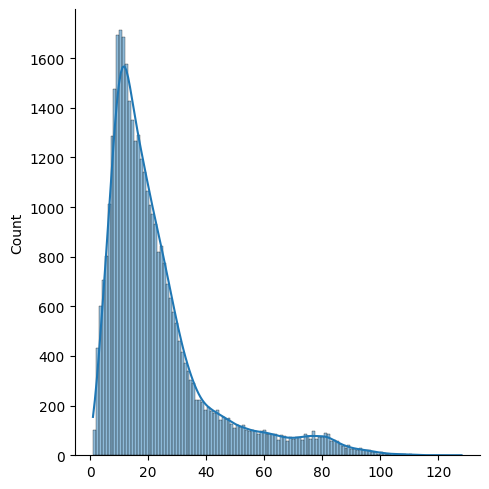

In [86]:
import seaborn as sns

sns.displot(length_list, kde=True)

## 모델링

Bert모델에 pytorch 코드 구현 자료
https://neptune.ai/blog/how-to-code-bert-using-pytorch-tutorial

BERT Classifier 모델입니다.

forward에서 사용하는 attention_mask는 gen_attention_mask에서 생성합니다.
<br /><br />

#### _, pooler = self.bert(...) 에 대한 설명

- bert에 Feed Forward 하여 앞서 input_transformer 적용 시 문장별로 맨 앞에 주었던 [CLS] 토큰에 대한 임베딩 벡터를 반환합니다. (pooled)
- 앞의 _는 bert의 output으로 전체 sequence에 대한 embedding 벡터입니다.

In [87]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
        self.classifier = nn.Linear(hidden_size , num_classes)

        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)

        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1

        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(),
                              attention_mask = attention_mask.to(token_ids.device), return_dict=False)

        if self.dr_rate:
            out = self.dropout(pooler)

        return self.classifier(out)

kobert = get_kobert_model()
model = BERTClassifier(kobert, dr_rate=0.5).to(device)

In [61]:
# class BERTRegressor(nn.Module):
#     def __init__(self,
#                  bert,
#                  hidden_size = 768,
#                  num_areas=4,
#                  dr_rate=None):
#         super(BERTRegressor, self).__init__()
#         self.bert = bert
#         self.dr_rate = dr_rate
#         self.regressor = nn.Linear(hidden_size , num_areas)
#         if dr_rate:
#             self.dropout = nn.Dropout(p=dr_rate)

#     def forward(self, inputs):
#         if type(self.bert) == DistilBertModel:
#             inputs.pop('token_type_ids')
#             sequence_output = self.bert(**inputs,
#                                   return_dict=False)
#             pooler = sequence_output[0][:, 0]
#         else:
#             _, pooler = self.bert(**inputs, return_dict=False)

#         if self.dr_rate:
#             out = self.dropout(pooler)
#         return self.regressor(out)


## 모델 학습

In [62]:
num_epochs = 5
learning_rate = 5e-5
warmup_ratio = 0.1
max_grad_norm = 1
log_interval = 50

In [63]:
'{:.5f}'.format(5e-5)

'0.00005'

In [ ]:
model # 모델 구조 확인

# 이름으로 가중치 freeze
for name, param in model.named_parameters():
    if name in ['가중치 학습할 layers']:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [88]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

# weight freeze
for param in model.bert.parameters():
    param.requires_grad = False

# for param in model.parameters():
#     param.requires_grad = False

# for param in model.features[-1].parameters():
#     param.requires_grad = True


# 옵티마이저, 손실함수 지정
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-8)
loss_fn = nn.CrossEntropyLoss().cuda()

t_total = len(train_loader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [65]:
from tqdm.auto import tqdm

In [66]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return acc

In [67]:
from copy import deepcopy

In [89]:
loss_history = [] # 전체 loss
avg_loss_hisroty = [] # epoch별 평균 loss
test_history = [] # validation accuracy
test_loss_history = [] # epoch별 평균 validation loss

best_acc = 0.0
best_acc_model = deepcopy(model)
for e in range(num_epochs):
    total_loss=0.0
    train_acc = 0.0
    test_acc = 0.0
    test_total_loss=0.0

    model.train() #훈련 선언
    for batch_id, ((token_ids, valid_length, segment_ids), label) in enumerate(tqdm(iter(train_loader))):
        optimizer.zero_grad()
        token_ids = token_ids.to(device)
        segment_ids = segment_ids.to(device)
        valid_length= valid_length
        label = label.to(device)
        out = model(token_ids, valid_length, segment_ids)

        #print(label.shape,out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_acc += calc_accuracy(out, label)

        if (batch_id+1) % log_interval == 0:
            print("[train]\tepoch: {}\t batch id: {}/{}\t train_loss: {:.4f}\t train_acc: {:.4f}".format(e+1, batch_id+1,
                len(train_loader), loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            loss_history.append(loss.data.cpu().numpy())
            total_loss+=loss.data.cpu().numpy()

    avg_loss=total_loss/len(train_loader) #epoch별 평균 loss값
    avg_loss_hisroty.append(avg_loss)

    model.eval() #모델평가
    for batch_id, ((token_ids, valid_length, segment_ids), label) in enumerate(tqdm(iter(valid_loader))):
        token_ids = token_ids.to(device)
        segment_ids = segment_ids.to(device)
        valid_length= valid_length
        label = label.to(device)
        with torch.no_grad():
            out = model(token_ids, valid_length, segment_ids)
            loss = loss_fn(out, label).detach()
            test_acc += calc_accuracy(out, label)
            test_total_loss += loss.data.cpu().numpy()
        test_history.append(test_acc / (batch_id+1))

    test_avg_loss=test_total_loss/len(valid_loader)
    test_loss_history.append(test_avg_loss)
    print("[valid]\tepoch: {}\t valid loss: {:.4f}\t valid acc: {:.4f}".format(e+1, test_avg_loss,
        test_acc/len(valid_loader)))

    if (test_acc / (batch_id+1)) > best_acc:
          best_acc = (test_acc / (batch_id+1))
          best_acc_model = deepcopy(model)


  0%|          | 0/586 [00:00<?, ?it/s]

[train]	epoch: 1	 batch id: 50/586	 train_loss: 0.6902	 train_acc: 0.5241
[train]	epoch: 1	 batch id: 100/586	 train_loss: 0.6540	 train_acc: 0.6070
[train]	epoch: 1	 batch id: 150/586	 train_loss: 0.4039	 train_acc: 0.6631
[train]	epoch: 1	 batch id: 200/586	 train_loss: 0.5442	 train_acc: 0.6927
[train]	epoch: 1	 batch id: 250/586	 train_loss: 0.3968	 train_acc: 0.7148
[train]	epoch: 1	 batch id: 300/586	 train_loss: 0.6247	 train_acc: 0.7312
[train]	epoch: 1	 batch id: 350/586	 train_loss: 0.3688	 train_acc: 0.7441
[train]	epoch: 1	 batch id: 400/586	 train_loss: 0.3412	 train_acc: 0.7557
[train]	epoch: 1	 batch id: 450/586	 train_loss: 0.4538	 train_acc: 0.7647
[train]	epoch: 1	 batch id: 500/586	 train_loss: 0.3142	 train_acc: 0.7728
[train]	epoch: 1	 batch id: 550/586	 train_loss: 0.3560	 train_acc: 0.7793


  0%|          | 0/196 [00:00<?, ?it/s]

[valid]	epoch: 1	 valid loss: 0.3495	 valid acc: 0.8402


  0%|          | 0/586 [00:00<?, ?it/s]

[train]	epoch: 2	 batch id: 50/586	 train_loss: 0.3689	 train_acc: 0.8516
[train]	epoch: 2	 batch id: 100/586	 train_loss: 0.4520	 train_acc: 0.8497
[train]	epoch: 2	 batch id: 150/586	 train_loss: 0.3163	 train_acc: 0.8556
[train]	epoch: 2	 batch id: 200/586	 train_loss: 0.2260	 train_acc: 0.8601
[train]	epoch: 2	 batch id: 250/586	 train_loss: 0.2953	 train_acc: 0.8629
[train]	epoch: 2	 batch id: 300/586	 train_loss: 0.3687	 train_acc: 0.8689
[train]	epoch: 2	 batch id: 350/586	 train_loss: 0.2170	 train_acc: 0.8724
[train]	epoch: 2	 batch id: 400/586	 train_loss: 0.2807	 train_acc: 0.8758
[train]	epoch: 2	 batch id: 450/586	 train_loss: 0.2876	 train_acc: 0.8785
[train]	epoch: 2	 batch id: 500/586	 train_loss: 0.0991	 train_acc: 0.8823
[train]	epoch: 2	 batch id: 550/586	 train_loss: 0.2358	 train_acc: 0.8838


  0%|          | 0/196 [00:00<?, ?it/s]

[valid]	epoch: 2	 valid loss: 0.3485	 valid acc: 0.8623


  0%|          | 0/586 [00:00<?, ?it/s]

[train]	epoch: 3	 batch id: 50/586	 train_loss: 0.3778	 train_acc: 0.9087
[train]	epoch: 3	 batch id: 100/586	 train_loss: 0.2619	 train_acc: 0.9094
[train]	epoch: 3	 batch id: 150/586	 train_loss: 0.2697	 train_acc: 0.9133
[train]	epoch: 3	 batch id: 200/586	 train_loss: 0.0938	 train_acc: 0.9191
[train]	epoch: 3	 batch id: 250/586	 train_loss: 0.1979	 train_acc: 0.9223
[train]	epoch: 3	 batch id: 300/586	 train_loss: 0.2810	 train_acc: 0.9255
[train]	epoch: 3	 batch id: 350/586	 train_loss: 0.1761	 train_acc: 0.9282
[train]	epoch: 3	 batch id: 400/586	 train_loss: 0.0383	 train_acc: 0.9303
[train]	epoch: 3	 batch id: 450/586	 train_loss: 0.1494	 train_acc: 0.9318
[train]	epoch: 3	 batch id: 500/586	 train_loss: 0.1020	 train_acc: 0.9334
[train]	epoch: 3	 batch id: 550/586	 train_loss: 0.1083	 train_acc: 0.9347


  0%|          | 0/196 [00:00<?, ?it/s]

[valid]	epoch: 3	 valid loss: 0.4701	 valid acc: 0.8717


  0%|          | 0/586 [00:00<?, ?it/s]

[train]	epoch: 4	 batch id: 50/586	 train_loss: 0.2761	 train_acc: 0.9419
[train]	epoch: 4	 batch id: 100/586	 train_loss: 0.1847	 train_acc: 0.9447
[train]	epoch: 4	 batch id: 150/586	 train_loss: 0.2053	 train_acc: 0.9501
[train]	epoch: 4	 batch id: 200/586	 train_loss: 0.0777	 train_acc: 0.9528
[train]	epoch: 4	 batch id: 250/586	 train_loss: 0.1302	 train_acc: 0.9560
[train]	epoch: 4	 batch id: 300/586	 train_loss: 0.2044	 train_acc: 0.9579
[train]	epoch: 4	 batch id: 350/586	 train_loss: 0.1312	 train_acc: 0.9591
[train]	epoch: 4	 batch id: 400/586	 train_loss: 0.0726	 train_acc: 0.9612
[train]	epoch: 4	 batch id: 450/586	 train_loss: 0.0967	 train_acc: 0.9625
[train]	epoch: 4	 batch id: 500/586	 train_loss: 0.0917	 train_acc: 0.9633
[train]	epoch: 4	 batch id: 550/586	 train_loss: 0.0684	 train_acc: 0.9642


  0%|          | 0/196 [00:00<?, ?it/s]

[valid]	epoch: 4	 valid loss: 0.4755	 valid acc: 0.8751


  0%|          | 0/586 [00:00<?, ?it/s]

[train]	epoch: 5	 batch id: 50/586	 train_loss: 0.2030	 train_acc: 0.9750
[train]	epoch: 5	 batch id: 100/586	 train_loss: 0.1085	 train_acc: 0.9717
[train]	epoch: 5	 batch id: 150/586	 train_loss: 0.1295	 train_acc: 0.9716
[train]	epoch: 5	 batch id: 200/586	 train_loss: 0.0340	 train_acc: 0.9737
[train]	epoch: 5	 batch id: 250/586	 train_loss: 0.0618	 train_acc: 0.9752
[train]	epoch: 5	 batch id: 300/586	 train_loss: 0.2188	 train_acc: 0.9762
[train]	epoch: 5	 batch id: 350/586	 train_loss: 0.0585	 train_acc: 0.9768
[train]	epoch: 5	 batch id: 400/586	 train_loss: 0.0218	 train_acc: 0.9779
[train]	epoch: 5	 batch id: 450/586	 train_loss: 0.0955	 train_acc: 0.9782
[train]	epoch: 5	 batch id: 500/586	 train_loss: 0.0289	 train_acc: 0.9788
[train]	epoch: 5	 batch id: 550/586	 train_loss: 0.0510	 train_acc: 0.9787


  0%|          | 0/196 [00:00<?, ?it/s]

[valid]	epoch: 5	 valid loss: 0.4982	 valid acc: 0.8725


In [73]:
best_acc

0.8263327205882354

In [74]:
test_acc/(batch_id+1)

0.8138327205882353

## 예측, 평가

학습때 사용하지 않은 데이터로 검증을 진행합니다.

전체적인 구조는 validation 때 사용한 코드와 비슷합니다.

In [69]:
predict_dataset = BERTDataset(input_transformer, test_sentences[:256], test_labels)
test_loader = torch.utils.data.DataLoader(predict_dataset, batch_size=batch_size, num_workers=2)

In [105]:
# parameter를 test_sentences로 받기
def predict(model, test_sentences, test_labels, device):
    # dataset, dataloader 정의
    pred_dataset = BERTDataset(input_transformer, test_sentences, test_labels)
    test_loader = torch.utils.data.DataLoader(pred_dataset, batch_size=batch_size, num_workers=0)

    model.eval() # gpu
    test_loss = 0.0
    test_acc = 0.0
    preds = torch.tensor([], dtype=torch.long) # cpu
    for (token_ids, valid_length, segment_ids), label in test_loader:
        token_ids = token_ids.to(device)
        segment_ids = segment_ids.to(device)
        valid_length = valid_length
        label = label.to(device)

        with torch.no_grad():
            out = model(token_ids, valid_length, segment_ids) # gpu
            loss = loss_fn(out, label).detach()
            test_acc += calc_accuracy(out, label)
            test_loss += loss.data.cpu().numpy()
            # print(out.shape) # batch_size, output (64, 2)
            pred = torch.argmax(out, dim=1) # (64, ) # gpu
            # out에 argmax 적용 (긍정, 부정 라벨 체크)
            # torch.cat (데이터 개수만큼 concat)
            preds = torch.cat([preds, pred.detach().cpu()])
    print(preds)

    preds = ['긍정' if pred == 1 else '부정' for pred in preds]

    return list(zip(test_sentences, preds)) # (1:1로 묶어서 반환)
    return test_loss/len(test_loader), test_acc/len(test_loader)

In [106]:
predict(model, test_sentences[:64], test_labels, device)

tensor([1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])


[('굳 ㅋ', '긍정'),
 ('GDNTOPCLASSINTHECLUB', '긍정'),
 ('뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아', '부정'),
 ('지루하지는 않은데 완전 막장임... 돈주고 보기에는....', '부정'),
 ('3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??', '부정'),
 ('음악이 주가 된, 최고의 음악영화', '긍정'),
 ('진정한 쓰레기', '부정'),
 ('마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다', '긍정'),
 ('갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한cg남무 아 그립다 동사서독같은 영화가 이건 3류아류작이다',
  '부정'),
 ('이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..', '긍정'),
 ('괜찮네요오랜만포켓몬스터잼밌어요', '긍정'),
 ('한국독립영화의 한계 그렇게 아버지가 된다와 비교됨', '긍정'),
 ('청춘은 아름답다 그 아름다움은 이성을 흔들어 놓는다. 찰나의 아름다움을 잘 포착한 섬세하고 아름다운 수채화같은 퀴어영화이다.',
  '긍정'),
 ('눈에 보이는 반전이었지만 영화의 흡인력은 사라지지 않았다.', '긍정'),
 ('"""스토리, 연출, 연기, 비주얼 등 영화의 기본 조차 안된 영화에 무슨 평을 해. 이런 영화 찍고도 김문옥 감독은 """"내가 영화 경력이 몇OO인데 조무래기들이 내 영화를 평론해?"""" 같은 마인드에 빠져있겠지?"""',
  '부정'),
 ('소위 ㅈ문가라는 평점은 뭐냐?', '부정'),
 ('최고!!!!!!!!!!!!!!!!', '긍정'),
 ('발연기 도저히 못보겠다 진짜 이렇게 연기를 못할거라곤 상상도 못했네', '부정'),
 ('나이스', '부정'),
 ('별 재미도없는거 우려먹어 .... 챔프에서 방송 몇번했더라 ? ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ', '부정'),
 ("'13일의 금요일', 

In [77]:
predict(model, test_loader, device)

# 0.5423678532242775
# 0.4374503493309021

(0.5423678532242775, 0.83203125)

In [90]:
while True:
    pass

KeyboardInterrupt: ignored